In [2]:
# ---------- Cell 1: Install (first run only) & imports ----------
# !pip install scikit-learn pandas matplotlib seaborn joblib --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import joblib


In [ ]:
# ---------- Cell 2: Upload heart.csv from your PC ----------
# from google.colab import files
# uploaded = files.upload()      # choose C:\Users\ARPAN MONDAL\Downloads\heart.csv
# It will show 'heart.csv' in /content after upload


Saving heart.csv to heart.csv


In [3]:
# ---------- Cell 3: Load dataframe ----------
df = pd.read_csv('heart.csv')     # if you renamed, change accordingly
print(f"Shape: {df.shape}")
df.head()


Shape: (918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
# ---------- Cell 4: Define features & target ----------
target_col = 'HeartDisease'
X = df.drop(columns=[target_col])
y = df[target_col]

# Identify categorical vs numeric automatically
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object','category']).columns.tolist()

# Build preprocessing pipeline
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

# Train / validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train rows: {X_train.shape[0]},  Validation rows: {X_val.shape[0]}")


Train rows: 734,  Validation rows: 184


In [5]:
# ---------- Cell 5: Fit Random Forest within a full pipeline ----------
rf_clf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('classifier', rf_clf)
])

model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Validation Accuracy : 0.902
ROC‑AUC            : 0.933

              precision    recall  f1-score   support

           0       0.92      0.85      0.89        82
           1       0.89      0.94      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



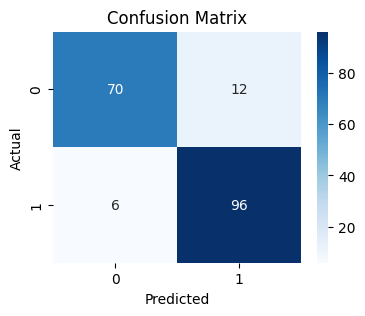

In [6]:
# ---------- Cell 6: Metrics ----------
y_pred = model.predict(X_val)
val_acc  = accuracy_score(y_val, y_pred)
roc_auc  = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])

print(f"Validation Accuracy : {val_acc:.3f}")
print(f"ROC‑AUC            : {roc_auc:.3f}\n")
print(classification_report(y_val, y_pred))

# Confusion‑matrix heat‑map
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()


In [7]:
# ---------- Cell 7: Single‑row prediction function ----------
def predict_heart_disease(input_dict):
    """
    input_dict: python dict with SAME column names as in heart.csv
                e.g. {
                    'Age': 54,
                    'Sex': 'M',
                    'ChestPainType': 'ASY',
                    'RestingBP': 140,
                    'Cholesterol': 239,
                    'FastingBS': 0,
                    'RestingECG': 'LVH',
                    'MaxHR': 160,
                    'ExerciseAngina': 'N',
                    'Oldpeak': 2.3,
                    'ST_Slope': 'Down'
                }
    Returns: prediction (0/1) and probability of heart disease
    """
    sample = pd.DataFrame([input_dict])
    prob = model.predict_proba(sample)[0,1]
    pred = int(prob >= 0.5)
    return pred, round(prob,3)

# ---- Quick test ----
test_patient = {
    'Age': 54, 'Sex': 'M', 'ChestPainType': 'ASY', 'RestingBP': 140,
    'Cholesterol': 239, 'FastingBS': 0, 'RestingECG': 'LVH',
    'MaxHR': 160, 'ExerciseAngina': 'N', 'Oldpeak': 2.3, 'ST_Slope': 'Down'
}
print("Sample prediction (1 = disease):", predict_heart_disease(test_patient))


Sample prediction (1 = disease): (1, 0.628)


In [8]:
# ---------- Cell 8: Persist the trained pipeline ----------
# joblib.dump(model, 'heart_model.joblib')
# print("Model saved → heart_model.joblib (download via left‑pane Files)")
# Save the trained pipeline to a file
joblib.dump(model, "heart_disease_model.pkl")


['heart_disease_model.pkl']